<a href="https://colab.research.google.com/github/bhushanrajs/sciml_project/blob/main/project_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Identification of Nonlinear Dynamical systems (SINDy)

In [ ]:
!pip3 install pysindy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
import pysindy as ps

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/sciml_project/main/analysis_data.csv')

tx_girders = {'Tx28' : {'D' : 28.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 6.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx34' : {'D' : 34.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 12.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx40' : {'D' : 40.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 18.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx46' : {'D' : 46.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 22.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx54' : {'D' : 54.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 30.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx62' : {'D' : 62.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 37.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx70' : {'D' : 70.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 45.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx84' : {'D' : 84.0, 'b1' : 58.0, 'b2' : 8.0, 'b3' : 38.0, 'b4' : 3.0, 'b5' : 3.0, 'd1' : 4.0, 'd2' : 3.5, 'd3' : 3.0, 'd4' : 55.75, 'd5' : 3.0, 'd6' : 6.0, 'd7' : 8.75}
              }

# bridge geometry data
L = df['L']/12 # span length in ft.
S = df['S']/12 # girder spacing in ft.
w_oh = df['w_oh']/12 # overhang width in ft.
ts = df['ts_U']/12 # thickness of overhang in ft.
girder = df['Girder Type']
D = []
for _, girder_type in girder.items():
  D.append(tx_girders[girder_type]['D'])
df['D'] = D

# intensity of railing dead load in kip/ft
b_rail = df['b_rail_left'] # width of railing
q_rail = (df['q_rail_left'] * b_rail * 12)/1000

# max bending moment in exterior girder G1 & interior girder G2 in kip-ft
bm1 = df['G1 - max_bm']/(1000*12)
bm2 = df['G2 - max_bm']/(1000*12)
bm3 = df['G3 - max_bm']/(1000*12)
bm4 = df['G4 - max_bm']/(1000*12)

# reaction in girders G1 & G2 in kip. (only A1 taken due to symmetry)
r1 = df['G1-A1-Y']/1000
r2 = df['G2-A1-Y']/1000
r3 = df['G3-A1-Y']/1000
r4 = df['G4-A1-Y']/1000

# line analysis with full railing load assumed to be applied on a girder
bm_line = q_rail * (L - 2*9/12)**2 / 8
r_line = q_rail * L / 2


# normalizing bending moments with respect to line analysis
n_bm1 = bm1 / bm_line
n_bm2 = bm2 / bm_line
n_bm3 = bm3 / bm_line
n_bm4 = bm4 / bm_line

# normalizing vertical reactions with respect to line analysis
n_r1 = r1 / r_line
n_r2 = r2 / r_line
n_r3 = r3 / r_line
n_r4 = r4 / r_line

# add the distribution factors to the dataframe
df['n_bm1'] = n_bm1
df['n_bm2'] = n_bm2
df['n_bm3'] = n_bm3
df['n_bm4'] = n_bm4
df['n_r1'] = n_r1
df['n_r2'] = n_r2
df['n_r3'] = n_r3
df['n_r4'] = n_r4

In [ ]:
X = np.stack((L, S, w_oh, ts, D), axis=-1)  # First column is x, second is y

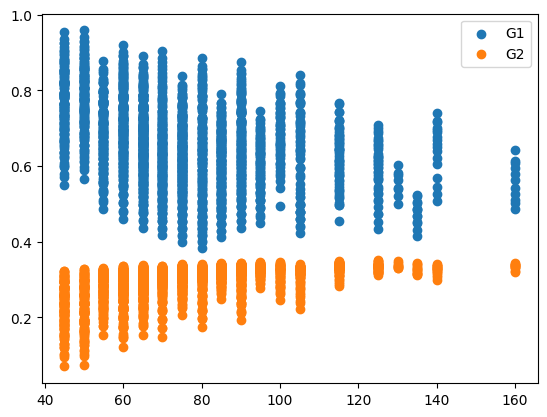

In [ ]:
plt.scatter(L, n_bm1, label="G1")
plt.scatter(L, n_bm2, label="G2")
plt.legend()

In [ ]:
differentiation_method = ps.differentiation.FiniteDifference(order=2)
feature_library = ps.feature_library.PolynomialLibrary(degree=3)
optimizer = ps.optimizers.STLSQ(threshold=0.2)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["L", "S",  "w_oh", "ts", "D"],
)

model.fit(X)

/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['L', 'S', 'w_oh', 'ts', 'D'],
      optimizer=STLSQ(threshold=0.2))

In [ ]:
feature_names = feature_library.get_feature_names(input_features=['L', 'S', 'w_oh', 'ts', 'D'])

print("Features in the Polynomial Library:")
print(feature_names)

coefficients = model.optimizer.coef_
print(coefficients)

model.print()

Features in the Polynomial Library:
['1', 'L', 'S', 'w_oh', 'ts', 'D', 'L^2', 'L S', 'L w_oh', 'L ts', 'L D', 'S^2', 'S w_oh', 'S ts', 'S D', 'w_oh^2', 'w_oh ts', 'w_oh D', 'ts^2', 'ts D', 'D^2', 'L^3', 'L^2 S', 'L^2 w_oh', 'L^2 ts', 'L^2 D', 'L S^2', 'L S w_oh', 'L S ts', 'L S D', 'L w_oh^2', 'L w_oh ts', 'L w_oh D', 'L ts^2', 'L ts D', 'L D^2', 'S^3', 'S^2 w_oh', 'S^2 ts', 'S^2 D', 'S w_oh^2', 'S w_oh ts', 'S w_oh D', 'S ts^2', 'S ts D', 'S D^2', 'w_oh^3', 'w_oh^2 ts', 'w_oh^2 D', 'w_oh ts^2', 'w_oh ts D', 'w_oh D^2', 'ts^3', 'ts^2 D', 'ts D^2', 'D^3']
[[-9.91521990e+10  0.00000000e+00  0.00000000e+00 -6.42204801e+11
   2.58962214e+11  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -4.61547852e-01  0.00000000e+00  3.25988770e-01
   1.67728783e+12  0.00000000e+00 -1.67975490e+11  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.000000

In [ ]:
sim = model.simulate([L, S, w_oh, ts, D])

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [1]:
import numpy as np

X = 2 * np.random.randn(100, 5)
y = 2.5382 * np.cos(X[:, 3]) + X[:, 0] ** 2 - 0.5

from pysr import PySRRegressor

model = PySRRegressor(
    model_selection="best",  # Result is mix of simplicity+accuracy
    niterations=40,
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(x, y) = (x - y)^2",
    # ^ Custom loss function (julia syntax)
)

model.fit(X, y)

print(model)

ModuleNotFoundError: ignored